# Python 2020 class
## Applied python/pandas/numpy/seaborn: Machine learning with proteomics

Lecture 15, Lili Blumenberg, May 19th, 2020. 

Notebook and data available at: https://github.com/MarkGrivainis/itp_spring_2020/tree/lecture_15

Environment requirements:
pandas  
numpy  
scipy  
seaborn  
matplotlib  
scikit-learn  
cptac  

We will be exploring an normalized semi-quantitative proteomics data set from endometrial cancer. The experiment is RNA-seq from mouse T-cells that have been challenged different numbers of times with peptides to simulate exhaustion. 

### First lets grab the notebook:
```bash
git add .
git commit -m ‘my changes’
git fetch
git checkout lecture/14
```

In [40]:
# Import the standard things we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition, model_selection, preprocessing, linear_model, impute
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix


# Make the seaborn plots a little prettier, make the font arial, 
# the backgrounds style white and the default fonts a little bigger. 
sns.set(font = 'arial', style = 'white', font_scale = 1.3)

# Prevent bits of the figures from getting cut off when saving. 
# This is my single favorite line of code. 
import matplotlib
matplotlib.rcParams.update({'savefig.bbox': 'tight'})

# Import data from CPTAC

We are going to get data in the way described by the tutorials for this package here:  
https://github.com/PayneLab/cptac/tree/master/docs

These datasets come as pandas dataframes, beautifully normalized and processed. 

In [41]:
import cptac
cptac.list_datasets()

Available datasets:

Dataset name                               Description     Data reuse status  \
                                                                               
Brca                                     breast cancer       no restrictions   
Ccrcc         clear cell renal cell carcinoma (kidney)       no restrictions   
Colon                                colorectal cancer       no restrictions   
Endometrial            endometrial carcinoma (uterine)       no restrictions   
Gbm                                       glioblastoma   publication embargo   
Hnscc                                    head and neck  password access only   
Lscc                      lung squamous cell carcinoma  password access only   
Luad                               lung adenocarcinoma   publication embargo   
Ovarian               high grade serous ovarian cancer       no restrictions   

Dataset name                              Publication link  
                                     

# Get some Data

In [42]:
cptac.download(dataset="endometrial")
en = cptac.Endometrial()

In [4]:
clin_data = en.get_clinical()
sample_types = clin_data.groupby('Proteomics_Tumor_Normal').groups
sample_types.keys()

dict_keys(['Adjacent_normal', 'Enriched_normal', 'Myometrium_normal', 'Tumor'])

In [73]:
sample_types['Tumor']

Index(['C3L-00006', 'C3L-00008', 'C3L-00032', 'C3L-00090', 'C3L-00098',
       'C3L-00136', 'C3L-00137', 'C3L-00139', 'C3L-00143', 'C3L-00145',
       'C3L-00156', 'C3L-00161', 'C3L-00358', 'C3L-00361', 'C3L-00362',
       'C3L-00413', 'C3L-00449', 'C3L-00563', 'C3L-00586', 'C3L-00601',
       'C3L-00605', 'C3L-00767', 'C3L-00769', 'C3L-00770', 'C3L-00771',
       'C3L-00780', 'C3L-00781', 'C3L-00905', 'C3L-00918', 'C3L-00921',
       'C3L-00932', 'C3L-00942', 'C3L-00946', 'C3L-00947', 'C3L-00949',
       'C3L-00961', 'C3L-00963', 'C3L-01246', 'C3L-01248', 'C3L-01249',
       'C3L-01252', 'C3L-01256', 'C3L-01257', 'C3L-01275', 'C3L-01282',
       'C3L-01304', 'C3L-01307', 'C3L-01311', 'C3L-01312', 'C3L-01744',
       'C3L-01925', 'C3N-00151', 'C3N-00200', 'C3N-00321', 'C3N-00322',
       'C3N-00323', 'C3N-00324', 'C3N-00326', 'C3N-00328', 'C3N-00333',
       'C3N-00334', 'C3N-00335', 'C3N-00337', 'C3N-00339', 'C3N-00340',
       'C3N-00377', 'C3N-00379', 'C3N-00383', 'C3N-00386', 'C3N-

In [5]:
sample_annotations = en.get_derived_molecular()
df = en.get_proteomics()

In [6]:
sample_annotations.head()

Name,Estrogen_Receptor,Estrogen_Receptor_%,Progesterone_Receptor,Progesterone_Receptor_%,MLH1,MLH2,MSH6,PMS2,p53,Other_IHC_specify,...,Log2_variant_total,Log2_SNP_total,Log2_INDEL_total,Genomics_subtype,Mutation_signature_C>A,Mutation_signature_C>G,Mutation_signature_C>T,Mutation_signature_T>C,Mutation_signature_T>A,Mutation_signature_T>G
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00006,Cannot be determined,NaN,Cannot be determined,NaN,Intact nuclear expression,Intact nuclear expression,Loss of nuclear expression,Intact nuclear expression,Cannot be determined,NaN,...,10.062046,9.984418,5.832890,MSI-H,8.300395,1.482213,72.529644,14.426877,1.383399,1.877470
C3L-00008,Cannot be determined,NaN,Cannot be determined,NaN,Intact nuclear expression,Intact nuclear expression,Intact nuclear expression,Loss of nuclear expression,Cannot be determined,NaN,...,8.861087,8.330917,7.169925,MSI-H,14.641745,2.803738,64.485981,15.264798,0.934579,1.869159
C3L-00032,Cannot be determined,NaN,Cannot be determined,NaN,Intact nuclear expression,Intact nuclear expression,Intact nuclear expression,Intact nuclear expression,Cannot be determined,NaN,...,5.321928,5.000000,3.169925,CNV_low,16.129032,3.225806,70.967742,3.225806,3.225806,3.225806
C3L-00090,Cannot be determined,NaN,Cannot be determined,NaN,Intact nuclear expression,Intact nuclear expression,Intact nuclear expression,Intact nuclear expression,Cannot be determined,NaN,...,5.672425,5.523562,2.584963,CNV_low,17.777778,8.888889,62.222222,8.888889,2.222222,0.000000
C3L-00098,Cannot be determined,NaN,Cannot be determined,NaN,Intact nuclear expression,Intact nuclear expression,Intact nuclear expression,Intact nuclear expression,Normal,NaN,...,6.108524,5.954196,3.000000,CNV_high,9.836066,13.114754,62.295082,3.278689,8.196721,3.278689


In [7]:
df.head()

Name,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,...,ZSWIM8,ZSWIM9,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00006,-1.180,-0.8630,-0.802,0.222,0.2560,0.6650,1.2800,-0.3390,0.412,-0.664,...,-0.08770,NaN,0.0229,0.1090,NaN,-0.332,-0.43300,-1.020,-0.1230,-0.0859
C3L-00008,-0.685,-1.0700,-0.684,0.984,0.1350,0.3340,1.3000,0.1390,1.330,-0.367,...,-0.03560,NaN,0.3630,1.0700,0.737,-0.564,-0.00461,-1.130,-0.0757,-0.4730
C3L-00032,-0.528,-1.3200,0.435,NaN,-0.2400,1.0400,-0.0213,-0.0479,0.419,-0.500,...,0.00112,-0.1450,0.0105,-0.1160,NaN,0.151,-0.07400,-0.540,0.3200,-0.4190
C3L-00090,-1.670,-1.1900,-0.443,0.243,-0.0993,0.7570,0.7400,-0.9290,0.229,-0.223,...,0.07250,-0.0552,-0.0714,0.0933,0.156,-0.398,-0.07520,-0.797,-0.0301,-0.4670
C3L-00098,-0.374,-0.0206,-0.537,0.311,0.3750,0.0131,-1.1000,NaN,0.565,-0.101,...,-0.17600,NaN,-1.2200,-0.5620,0.937,-0.646,0.20700,-1.850,-0.1760,0.0513


In [8]:
df.sample(5)

Name,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,...,ZSWIM8,ZSWIM9,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3N-00386,-0.979,-1.1100,0.774,-1.16,-0.0186,0.447,0.849,-0.239,0.2540,0.127,...,0.5190,-0.650,0.298,0.489,0.0383,0.283,-0.451,-0.659,0.0534,0.3010
C3N-01211,-0.636,-0.3710,0.973,NaN,0.6370,-0.166,-0.122,0.232,0.3790,-0.195,...,-0.4160,-0.751,0.179,0.658,0.4700,0.270,-0.148,-0.139,-0.0299,0.1310
C3L-00361,-1.340,-1.8700,-0.258,NaN,0.1290,2.560,1.030,-0.396,-0.0763,-0.476,...,0.0330,-0.419,0.327,0.103,NaN,0.638,-0.514,-1.420,0.2180,-0.0611
C3L-01744,-0.506,-0.2170,-1.180,-1.00,0.1390,0.654,0.789,-0.547,0.4970,-0.241,...,0.0542,-0.678,0.345,0.886,1.5100,-0.621,-0.245,-1.020,0.2680,-0.0204
C3L-01246.N,0.671,0.0618,NaN,NaN,-0.1100,-1.370,-0.549,0.313,-0.7910,0.213,...,-0.2970,NaN,-0.457,-0.912,NaN,0.202,0.393,1.360,0.0936,0.2980


In [9]:
# Lets check for sample duplicates and gene duplicates
print(df.index[df.index.duplicated()])
print(df.columns[df.columns.duplicated()])

# All good!

Index([], dtype='object', name='Patient_ID')
Index([], dtype='object', name='Name')


In [10]:
# This all the info we have on the tumors
sample_annotations.columns

Index(['Estrogen_Receptor', 'Estrogen_Receptor_%', 'Progesterone_Receptor',
       'Progesterone_Receptor_%', 'MLH1', 'MLH2', 'MSH6', 'PMS2', 'p53',
       'Other_IHC_specify',
       ...
       'Log2_variant_total', 'Log2_SNP_total', 'Log2_INDEL_total',
       'Genomics_subtype', 'Mutation_signature_C>A', 'Mutation_signature_C>G',
       'Mutation_signature_C>T', 'Mutation_signature_T>C',
       'Mutation_signature_T>A', 'Mutation_signature_T>G'],
      dtype='object', name='Name', length=125)

# Getting to know the data: visualization

This data is already column normalized (adjusted for coverage) and row normalized to some extent (everything is represented as the log2 of s fold change compared to a standard)

Let's make sure the look of the data matches what we expect. 

In [44]:
df.shape

(144, 10999)

In [45]:
df.mean()

Name
A1BG      0.058300
A2M       0.008676
A2ML1     0.317285
A4GALT    0.095133
AAAS      0.027387
            ...   
ZXDC     -0.002195
ZYG11B   -0.024433
ZYX       0.158869
ZZEF1    -0.006990
ZZZ3      0.029192
Length: 10999, dtype: float64

Text(0, 0.5, 'proportion of samples')

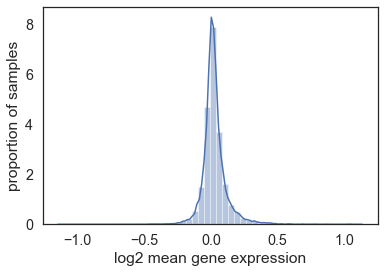

In [12]:
sns.distplot(df.mean())
plt.xlabel('log2 mean protein expression')
plt.ylabel('proportion of samples')

In [46]:
df.sample(25, axis=1)

Name,FLT1,EMC8,PDCD2L,TMEM59,GFER,CDS1,SNRPA1,CLDN4,CEP350,COX5A,...,RPP30,TPK1,TCERG1,TAF5L,PTPN18,KIAA0930,CCDC106,TEF,PLA2G16,MED6
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00006,-0.492000,0.1580,-0.263,-0.1710,0.349,0.91800,0.1950,0.4630,-0.3100,1.2000,...,0.5050,-0.6160,0.141000,0.03040,-0.6310,0.1170,NaN,NaN,NaN,-0.0537
C3L-00008,-0.105000,-0.1490,0.731,0.1330,-0.139,0.65700,-0.0146,0.4400,-0.1090,0.4310,...,0.3310,-2.0200,-0.000854,0.01210,-1.0100,0.0158,NaN,NaN,-0.261,0.1230
C3L-00032,0.000163,0.4910,-0.130,0.0000,-0.182,1.02000,-0.0994,0.4800,0.1980,0.2530,...,0.0095,0.0281,-0.091000,0.13200,0.3370,0.0800,NaN,NaN,NaN,-0.2590
C3L-00090,0.166000,-0.0299,0.359,-0.4620,-0.279,1.43000,0.2080,0.3920,-0.2530,0.0850,...,0.3350,-0.7150,-0.049800,-0.11200,-0.4010,-0.2160,NaN,NaN,NaN,-0.0528
C3L-00098,-0.374000,0.3070,1.200,1.5100,0.609,0.64500,-0.0529,-0.0981,0.0699,0.3800,...,0.3460,2.0700,-0.169000,-0.10300,0.7850,1.1400,0.905,-0.181,-0.360,-0.0724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NX5.N,-0.290000,-0.4030,-0.962,-0.0435,0.111,-0.32000,0.2530,-0.8960,-0.0241,-0.0323,...,-0.1420,0.4110,0.325000,-0.06730,-0.4480,0.0338,0.174,NaN,0.698,0.1440
NX6.N,-0.101000,0.0040,-0.924,-0.0214,0.195,-0.59100,0.0136,-0.9230,-0.2170,-0.0356,...,-0.1490,-0.2890,-0.009750,-0.07870,-0.1020,0.0192,-0.136,NaN,0.115,0.2580
NX7.N,-0.112000,-0.3380,-0.969,0.0605,0.327,-0.84600,0.2260,-0.7030,-0.1590,-0.1130,...,-0.1070,-0.1160,0.215000,-0.04260,-0.4960,0.2510,0.136,NaN,0.305,0.2780


Text(0, 0.5, 'proportion of samples')

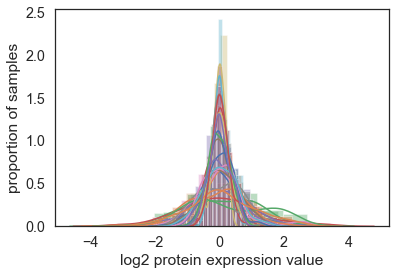

In [47]:
for gene, col in df.sample(25, axis=1).iteritems():
    sns.distplot(col)
    
plt.xlabel('log2 protein expression value')
plt.ylabel('proportion of samples')
# Row normalization looks good    

(-4.0, 4.0)

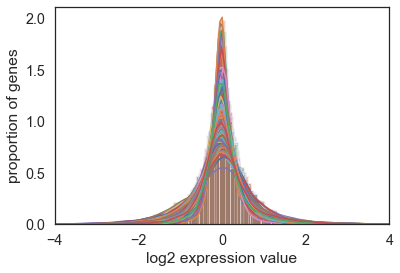

In [48]:
for sample, row in df.iterrows():
    sns.distplot(row)
plt.xlabel('log2 expression value')
plt.ylabel('proportion of genes')
_ = plt.xlim(-4, 4)

In [51]:
df.isnull().sum()

Name
A1BG       0
A2M        0
A2ML1     18
A4GALT    48
AAAS       0
          ..
ZXDC       0
ZYG11B     0
ZYX        0
ZZEF1      0
ZZZ3       0
Length: 10999, dtype: int64

Text(0, 0.5, '# genes')

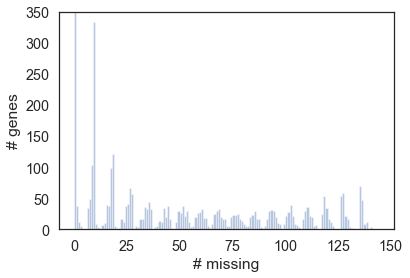

In [52]:
# Let's check the distribution of missing values per gene
sns.distplot(df.isnull().sum(), kde=False, bins=144)
plt.ylim(0, 350)
plt.xlabel('# missing')
plt.ylabel('# genes')
# Interesting pattern!

In [16]:
# This periodicity can be explained from the experimental design:

exp_des = en.get_experimental_design()
exp_des.head()

Name,Proteomics_TMT_batch,Proteomics_TMT_plex,Proteomics_TMT_channel,Proteomics_Parent_Sample_IDs,Proteomics_Aliquot_ID,Proteomics_OCT,WXS_normal_sample_type,WXS_normal_filename,WXS_normal_UUID,WXS_tumor_sample_type,...,RNAseq_R1_sample_type,RNAseq_R1_filename,RNAseq_R1_UUID,RNAseq_R2_sample_type,RNAseq_R2_filename,RNAseq_R2_UUID,miRNAseq_sample_type,miRNAseq_UUID,Methylation_available,Methylation_quality
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00006,2,5,128N,C3L-00006-01,CPT0001460012,No,Blood_normal,92b5e534-6cb0-43eb-8147-ce7d18526f5e_gdc_realn...,53dbb4d6-ce9d-4145-a33a-0c4d67e655df,Tumor,...,Tumor,170802_UNC31-K00269_0072_AHK3GVBBXX_TAGCTT_S17...,8a1efc47-1c29-417f-a425-cdbd09565dcb,Tumor,170802_UNC31-K00269_0072_AHK3GVBBXX_TAGCTT_S17...,8c3fe9b7-7acd-4867-8d9c-a8e5d1516eda,Tumor,37bcba98-1094-459e-83ae-c23a602416fb,YES,PASS
C3L-00008,4,16,130N,C3L-00008-01,CPT0001300009,No,Blood_normal,243bfb3c-d06b-4de5-a6c3-7fa7e2c5fb74_gdc_realn...,90257622-6bcc-43e7-a04f-f7397975d038,Tumor,...,Tumor,170802_UNC31-K00269_0072_AHK3GVBBXX_GGCTAC_S22...,555725e8-cba5-4676-9b0a-80100cbf9f47,Tumor,170802_UNC31-K00269_0072_AHK3GVBBXX_GGCTAC_S22...,15235b12-b67a-4678-acc4-ed03d642bd5e,Tumor,492b50d8-ec35-46e7-a65d-06512aaee394,YES,PASS
C3L-00032,1,2,131,C3L-00032-01,CPT0001420009,No,Blood_normal,97e153c1-7be4-4d7b-9d30-9545b56e6ddb_gdc_realn...,75a4369c-5247-427d-aabc-3157d08f2d8f,Tumor,...,Tumor,170802_UNC31-K00269_0072_AHK3GVBBXX_GTCCGC_S18...,9ae968f3-691d-4db3-9977-1ab3e5af9085,Tumor,170802_UNC31-K00269_0072_AHK3GVBBXX_GTCCGC_S18...,423b6b09-02aa-4f47-9241-f75c1dad1161,Tumor,1794ff56-db2d-4d1a-8758-cab7fe3d98c1,YES,PASS
C3L-00090,3,12,129C,C3L-00090-01,CPT0001140003,No,Blood_normal,7959d3f4-80cb-45f5-99ea-248ac2059877_gdc_realn...,d74368b7-1924-4c44-8079-1858f7ebf85a,Tumor,...,Tumor,170802_UNC31-K00269_0072_AHK3GVBBXX_GAGTGG_S10...,8ce5618d-9ff6-40f9-aeea-8d8e1633ae38,Tumor,170802_UNC31-K00269_0072_AHK3GVBBXX_GAGTGG_S10...,06d3fd4a-a623-4146-8500-4f1f17235253,Tumor,a6524c2d-d7dd-4629-980e-b45dbdc92c49,YES,PASS
C3L-00098,4,14,129N,C3L-00098-02,CPT0000980012,No,Blood_normal,0f46b9b0-6bff-4156-b505-669d72cc9428_gdc_realn...,b58bdcce-b807-4958-814d-3576dee3ae0c,Tumor,...,Tumor,170802_UNC31-K00269_0072_AHK3GVBBXX_TTAGGC_S8_...,31252ba9-e052-4b77-809a-f936379ae00c,Tumor,170802_UNC31-K00269_0072_AHK3GVBBXX_TTAGGC_S8_...,23be22ae-de50-4d74-a7c0-c890adbc662a,NaN,NaN,YES,PASS


In [17]:
exp_des['Proteomics_TMT_plex'].value_counts()
# This traslates to 9 instances of 17, 9 instances of 8, etc.
# When a protein isn't detected it's not detected for that whole plex, hence the periodicity of the missing values.
# NB This function is EXTREMELY helpful for making sure that categorical table has the correct values in it. 

17    9
8     9
3     9
4     9
5     9
6     9
7     9
9     9
12    9
14    9
1     9
16    8
13    8
15    8
2     8
10    7
11    6
Name: Proteomics_TMT_plex, dtype: int64

### challenge: prove to yourself that this is a batch effect. 

# Defining biological questions to decide on a machine learning approach

Endometrial cancer subtypes are defined from genomics--DNA sequencing--based on the pattern of mutations. Do these subtypes really represent functional differences at the protein level? Specifically focusing on the micro-satellite instability-high (MSI-H) subtype. 
+ Can we make a classifier that can predict the MSI-H subtype based on protein expression?

We want to design an *in situ* hybridization (ISH) experiment that can find MSI-H cases. 
+ What protein expression features are the most predictive of MSI-H genomic phenotype?

Let's use machine learning with sklearn to answer these questions

# Scikit-learn

## Preprocessing

1. We don't want to predict on features withmany missing values, it is more likely to be over fitting. **Remove features with many missing values**. 

2. Features without much variation are unlikely to be informative, and will just add to the curse of dimensionality. **Remove features with low variance**. 

3. Most ML algorithms cannot tolerate any missing values. **Impute remaining missing values**

In [53]:
data = df.copy()

In [54]:
data.shape

(144, 10999)

In [57]:
int(len(data)*0.5)

72

In [58]:
data = data.dropna(thresh=int(len(data)*0.5), axis=1)

In [59]:
data.shape

(144, 9868)

In [60]:
model = impute.KNNImputer(n_neighbors=3)

imputed_data = model.fit_transform(data)

In [62]:
imputed_data.shape

(144, 9868)

In [63]:
imputed_data = pd.DataFrame(imputed_data, index=data.index, columns=data.columns)

In [67]:
imputed_data.isnull().sum().sum()

0

In [69]:
sample_annotations['Genomics_subtype']

Patient_ID
C3L-00006            MSI-H
C3L-00008            MSI-H
C3L-00032          CNV_low
C3L-00090          CNV_low
C3L-00098         CNV_high
                 ...      
NX5.N        Normal tissue
NX6.N        Normal tissue
NX7.N        Normal tissue
NX8.N        Normal tissue
NX9.N        Normal tissue
Name: Genomics_subtype, Length: 144, dtype: object

In [22]:
sample_annotations.loc[sample_annotations['Genomics_subtype'].isnull(), 'Genomics_subtype'] = 'Normal tissue'

In [70]:
pca_transformed

,PC1,PC2,Genomics_subtype
Patient_ID,,,
C3L-00006,-23.686246,1.284108,MSI-H
C3L-00008,-22.390845,4.989212,MSI-H
C3L-00032,-5.830841,-11.773179,CNV_low
C3L-00090,-19.667623,-5.545731,CNV_low
C3L-00098,-38.812530,30.881887,CNV_high
...,...,...,...
C3N-01520,-26.502764,6.705697,MSI-H
C3N-01521,-31.366465,13.660191,CNV_high
C3N-01537,-9.433915,12.580585,CNV_high


Text(57.355033791666685, 0.5, 'PC1 - 0.07 explained variance')

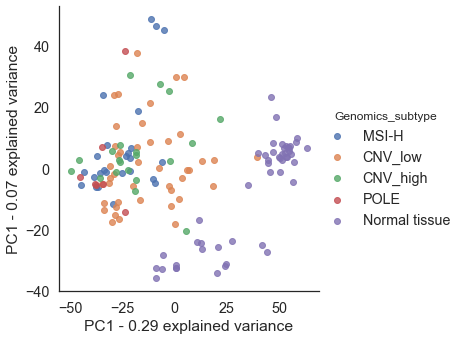

In [71]:
pca = decomposition.PCA(n_components=2)
pca_transformed = pca.fit_transform(imputed_data)
pca_transformed = pd.DataFrame(pca_transformed, index=imputed_data.index, columns=['PC1', 'PC2'])
pca_transformed = pd.concat([pca_transformed, sample_annotations[['Genomics_subtype']]], axis=1)

sns.lmplot(x='PC1', y='PC2', data=pca_transformed, hue='Genomics_subtype', fit_reg=False)
plt.xlabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[0])
plt.ylabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[1])

Text(53.179157055555564, 0.5, 'PC1 - 0.09 explained variance')

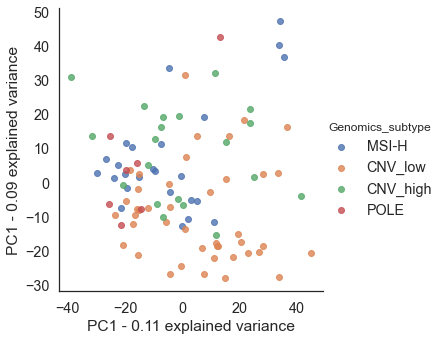

In [24]:
# Removing normal samples. They're adding HUGE variation in the data without a lot of information. 
tumors = imputed_data.loc[sample_types['Tumor']]

pca = decomposition.PCA(n_components=2)
pca_transformed = pca.fit_transform(tumors)
pca_transformed = pd.DataFrame(pca_transformed, index=tumors.index, columns=['PC1', 'PC2'])
pca_transformed = pd.concat([pca_transformed, sample_annotations[['Genomics_subtype']]], join='inner', axis=1)

sns.lmplot(x='PC1', y='PC2', data=pca_transformed, hue='Genomics_subtype', fit_reg=False)
plt.xlabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[0])
plt.ylabel('PC1 - %.2f explained variance'  % pca.explained_variance_ratio_[1])

### PCA doesn't make this problem look easy. 

In [25]:
# Let's go back and make sure that the TUMORS have at least 50% values there. 

temp = data.loc[sample_types['Tumor']].dropna(thresh=int(len(data)*0.5), axis=1)

model = impute.KNNImputer(n_neighbors=3)
tumors = model.fit_transform(temp)
tumors = pd.DataFrame(tumors, index=temp.index, columns=temp.columns)

In [75]:
tumors.std()

Name
A1BG      0.578724
A2M       0.724195
A2ML1     1.203397
AACS      0.549711
AADAT     0.631638
            ...   
ZWILCH    0.554500
ZWINT     0.528083
ZXDC      0.450050
ZYX       0.675080
ZZZ3      0.311229
Length: 7357, dtype: float64

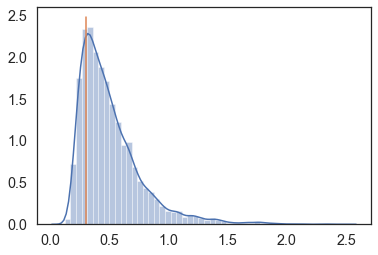

In [26]:
# Filter for high variance
ax = sns.distplot(tumors.std())
plt.plot([0.3, 0.3], ax.get_ylim())

In [27]:
# let's take genes with a std > 0.3

tumors = tumors.loc[:, (tumors.std()> 0.3)]

In [28]:
tumors.shape

(95, 7357)

### Let's see how well logitistic regression does. 

In [77]:
sample_annotations.loc[tumors.index, 'Genomics_subtype'] == 'MSI-H'

Patient_ID
C3L-00006       MSI-H
C3L-00008       MSI-H
C3L-00032     CNV_low
C3L-00090     CNV_low
C3L-00098    CNV_high
               ...   
C3N-01520       MSI-H
C3N-01521    CNV_high
C3N-01537    CNV_high
C3N-01802    CNV_high
C3N-01825    CNV_high
Name: Genomics_subtype, Length: 95, dtype: object

In [29]:
labels = (sample_annotations.loc[tumors.index, 'Genomics_subtype'] == 'MSI-H')
labels

Patient_ID
C3L-00006     True
C3L-00008     True
C3L-00032    False
C3L-00090    False
C3L-00098    False
             ...  
C3N-01520     True
C3N-01521    False
C3N-01537    False
C3N-01802    False
C3N-01825    False
Name: Genomics_subtype, Length: 95, dtype: bool

In [30]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    tumors, labels, test_size=0.2
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(76, 7357)
(19, 7357)
(76,)
(19,)


In [80]:
# create a new logistic regression model
# There are many different solvers: 
# .  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#   They all have their strenghts/weaknesses
classifier = linear_model.LogisticRegression(random_state=0, solver='lbfgs')


# train the model using the training data
classifier.fit(X_train, y_train)


# now that the model has been trained, predict the classes in the test set
pred = classifier.predict(X_test)


# predict outputs labels, decision_function outputs the confidence scores
y_scores = classifier.decision_function(X_test)


# print the accuracy sum(predicted == actual) / len(labels)
print(accuracy_score(y_test, pred))

0.8947368421052632


In [81]:
pred

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False])

In [82]:
y_scores

array([-8.32220673, -0.77409334, -4.68666455, -6.56502055, -3.03885613,
       -8.68076669, -6.93225721, -1.37916424, -0.73131268, -4.34243332,
       -1.93496474, -4.79230305, -3.58163441, -6.70921565, -7.52553154,
       -3.70588923,  0.82130661, -3.94599485, -3.65850989])

In [32]:
# scoring the model will return the accuracy
# this uses the test features and test labels
classifier.score(X_test, y_test)

0.8947368421052632

In [33]:
# the roc curve function takes the true labels and confidence scores
#  do not use the predicted labels as this will not calculate the correct curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
# auc is caculated using the false positive rate and true positive rate
roc_auc = auc(fpr, tpr)

In [84]:
y_scores

array([-8.32220673, -0.77409334, -4.68666455, -6.56502055, -3.03885613,
       -8.68076669, -6.93225721, -1.37916424, -0.73131268, -4.34243332,
       -1.93496474, -4.79230305, -3.58163441, -6.70921565, -7.52553154,
       -3.70588923,  0.82130661, -3.94599485, -3.65850989])

In [85]:
tpr

array([0.        , 0.33333333, 0.66666667, 0.66666667, 1.        ,
       1.        ])

In [83]:
fpr

array([0.    , 0.    , 0.    , 0.0625, 0.0625, 1.    ])

In [86]:
roc_auc

0.9791666666666666

# Visualize results

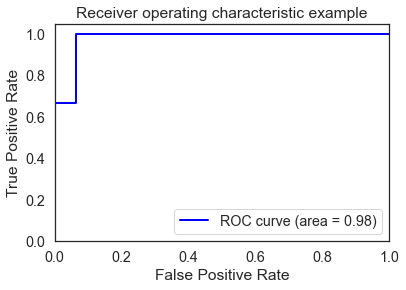

In [34]:
# FROM SKLEARN DOCS: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
# Plot the ROC curve using the previously calculated values

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Now we have a classifier that can predict MSI-H status from protein expression data. That's great! 

# Question 2: what features are the most predictive?

We could use these for a ISH experiment

In [35]:
tumors.shape

(95, 7357)

In [87]:
classifier.coef_

array([[-0.00622801,  0.00243918, -0.02518165, ..., -0.00056879,
         0.00238448, -0.00311786]])

In [36]:
classifier.coef_.shape

(1, 7357)

In [37]:
coefficients = pd.DataFrame(classifier.coef_.T, index=tumors.columns, columns=['coefficients'])
coefficients.sort_values('coefficients')
# This ordered list of genes would be a good input for a GSEA analysis. 

,coefficients
Name,
MLH1,-0.094444
WIF1,-0.078616
PMS2,-0.074925
TUBB2B,-0.073181
HOXB7,-0.065876
...,...
ADH1C,0.061751
SERPINA5,0.062684
S100A1,0.078191


In [90]:
coefficients.sort_values('coefficients').index[0:5]

Index(['MLH1', 'WIF1', 'PMS2', 'TUBB2B', 'HOXB7'], dtype='object', name='Name')

In [91]:
coefficients.sort_values('coefficients').index[-5:]

Index(['ADH1C', 'SERPINA5', 'S100A1', 'AKR1B10', 'RPL22L1'], dtype='object', name='Name')

In [38]:
top_negative_predictors = list(coefficients.sort_values('coefficients').index[0:5])
print(top_negative_predictors)

top_positive_predictors = list(coefficients.sort_values('coefficients').index[-5:])
print(top_positive_predictors)

genes_to_show = top_negative_predictors + top_positive_predictors

['MLH1', 'WIF1', 'PMS2', 'TUBB2B', 'HOXB7']
['ADH1C', 'SERPINA5', 'S100A1', 'AKR1B10', 'RPL22L1']


In [92]:
subtypes

array(['MSI-H', 'CNV_low', 'CNV_high', 'POLE', 'Normal tissue'],
      dtype=object)

In [99]:
colors = dict(zip(subtypes, sns.color_palette(n_colors=len(subtypes)).as_hex()))

{'MSI-H': '#4c72b0',
 'CNV_low': '#dd8452',
 'CNV_high': '#55a868',
 'POLE': '#c44e52',
 'Normal tissue': '#8172b3'}

In [104]:
sample_annotations[['Genomics_subtype']].replace(colors)

Name,Genomics_subtype
Patient_ID,
C3L-00006,#4c72b0
C3L-00008,#4c72b0
C3L-00032,#dd8452
C3L-00090,#dd8452
C3L-00098,#55a868
...,...
NX5.N,#8172b3
NX6.N,#8172b3
NX7.N,#8172b3


dict_keys(['MSI-H', 'CNV_low', 'CNV_high', 'POLE', 'Normal tissue'])


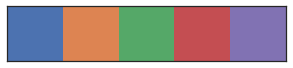

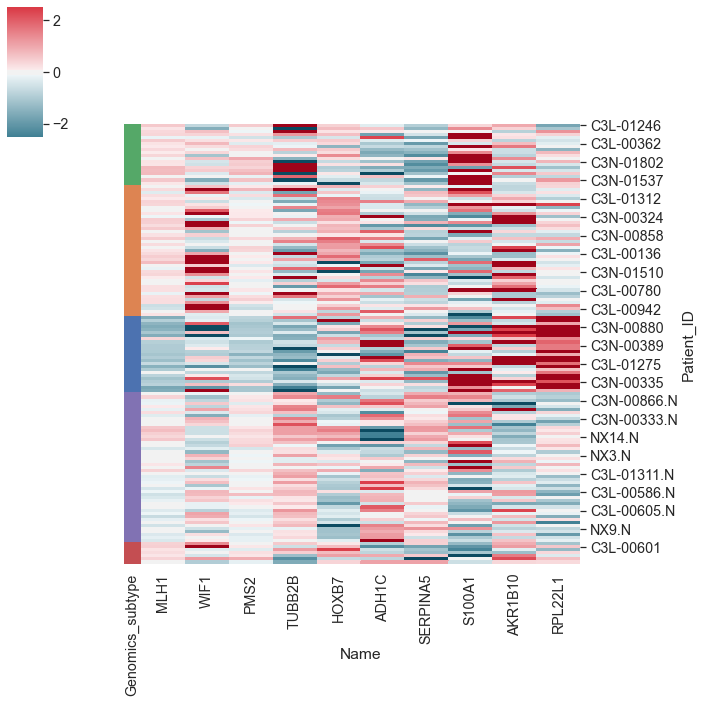

In [106]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap.set_bad('#BDBDBD')
cmap.set_over('#9E031A')
cmap.set_under('#0C4A60')

subtypes = sample_annotations['Genomics_subtype'].unique()
colors = dict(zip(subtypes, sns.color_palette(n_colors=len(subtypes)).as_hex()))

row_order = sample_annotations['Genomics_subtype'].sort_values().index

print(colors.keys())
sns.palplot(colors.values())
sns.clustermap(
    imputed_data.loc[row_order, genes_to_show],
    row_colors=sample_annotations[['Genomics_subtype']].replace(colors), 
    col_cluster=False, 
    row_cluster=False,
    cmap=cmap,
    vmin=-2.5, vmax=2.5,
)

## Cool! We re-discovered MLH1 missing expression as a marker. RPL22L1 looks like a good positive marker. 